In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

K = 10

In [ ]:
from PULS.evaluation import evaluate_shifted_pi_estimation

dataset_name = 'Gauss'
mean = 0.5
n = 1000
label_frequency = 0.5
pi_grid = [0.2, 0.4, 0.6, 0.8]

df = evaluate_shifted_pi_estimation(dataset_name, mean, n, label_frequency, pi_grid, convert_to_df=True)
df['value'] = round(df['mae'], 3).astype(str) + ' +- ' + round(df['std_mae'], 3).astype(str)
mae_results = df[["pi", "new_pi", "method", "value"]]
mae_results = mae_results.pivot(index=["pi", "new_pi"], columns="method", values="value")
mae_results = mae_results.rename(columns={"DRE": "DRPU"})
mae_results

method                DRPU             KM1             KM2
pi  new_pi                                                
0.2 0.2     0.082 +- 0.045  0.343 +- 0.048  0.228 +- 0.027
    0.4      0.04 +- 0.042  0.338 +- 0.064  0.134 +- 0.054
    0.6     0.064 +- 0.041  0.543 +- 0.138  0.401 +- 0.135
    0.8     0.181 +- 0.038    0.787 +- 0.0   0.68 +- 0.095
0.4 0.2     0.116 +- 0.059  0.323 +- 0.048  0.261 +- 0.035
    0.4     0.083 +- 0.054  0.307 +- 0.063   0.149 +- 0.03
    0.6     0.064 +- 0.053  0.509 +- 0.164  0.297 +- 0.139
    0.8     0.122 +- 0.095    0.787 +- 0.0  0.653 +- 0.116
0.6 0.2     0.125 +- 0.035  0.317 +- 0.054  0.267 +- 0.039
    0.4     0.077 +- 0.045   0.309 +- 0.06   0.17 +- 0.025
    0.6     0.064 +- 0.046  0.428 +- 0.206  0.219 +- 0.174
    0.8     0.137 +- 0.066    0.787 +- 0.0  0.643 +- 0.124
0.8 0.2     0.166 +- 0.073  0.307 +- 0.034  0.273 +- 0.024
    0.4     0.105 +- 0.056  0.295 +- 0.043  0.182 +- 0.027
    0.6     0.059 +- 0.036  0.435 +- 0.196  0.231 +- 0.175
    0.8     0.097 +- 0.076    0.787 +- 0.0  0.632 +- 0.109

In [1]:
# gauss
from PULS.models import LabelShiftConfig
from PULS.dataset import Gauss_PULS
from PULS.experiment import PULSExperiment

from nnPU.dataset import SCAR_CC_Labeler
from nnPU.dataset_configs import DatasetConfig
from nnPU.experiment_config import ExperimentConfig
from nnPU.loss import nnPUccLoss

K = 10
n = 1000
label_frequency = 0.5

for train_pi in [0.2, 0.4, 0.6, 0.8]:
    for test_pi in [0.2, 0.4, 0.6, 0.8]:
        for exp_number in range(0, K):

            label_shift_config = LabelShiftConfig(train_prior=train_pi, train_n_samples=n, test_prior=test_pi, test_n_samples=n)

            dataset_config = DatasetConfig(
                f"Gauss/{label_shift_config.train_n_samples or 'all'}/0.5/{label_shift_config.train_prior or 'all'}/{label_shift_config.test_prior or 'all'}",
                DatasetClass=Gauss_PULS,
                PULabelerClass=SCAR_CC_Labeler,
            )
            
            gauss_experiment_config = ExperimentConfig(
                PULoss=nnPUccLoss,
                dataset_config=dataset_config,
                label_frequency=label_frequency,
                exp_number=exp_number,
            )

            experiment = PULSExperiment(experiment_config=gauss_experiment_config, label_shift_config=label_shift_config)
            experiment.run()
            experiment.test_shifted()

            print(experiment.metrics)
            print(experiment.test_pis)

n_pos=2000, n_neg=2000, prior=0.5
n_pos_new=333, n_neg_new=667, n_samples=1000, U_max=2500
P_samples=167, U_samples=834, n_samples=1000, c=0.5
n_pos=2000, n_neg=2000, prior=0.5
n_pos_new=200, n_neg_new=800, n_samples=1000, U_max=2500
P_samples=0, U_samples=1000, n_samples=1000, c=0
Train set prior: 0.19904077053070068
Epoch: 1/50
3/3 [========] - 4s 1s/step - loss: 0.5008 - acc: 0.4901 - test_loss: 0.4626 - test_accuracy: 20.0000 - pos_fraction: 1.0000
Epoch: 2/50
3/3 [========] - 0s 58ms/step - loss: 0.4975 - acc: 0.5210 - test_loss: 0.4649 - test_accuracy: 20.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 65ms/step - loss: 0.4947 - acc: 0.5320 - test_loss: 0.4667 - test_accuracy: 20.2000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 88ms/step - loss: 0.4901 - acc: 0.5401 - test_loss: 0.4678 - test_accuracy: 20.6000 - pos_fraction: 0.9900
Epoch: 5/50
3/3 [========] - 0s 56ms/step - loss: 0.4866 - acc: 0.5553 - test_loss: 0.4684 - test_accuracy: 20.8000 - pos_frac

/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4638 - acc: 0.6429 - test_loss: 0.4141 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4596 - acc: 0.6579 - test_loss: 0.4096 - test_accuracy: 79.7000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4565 - acc: 0.6746 - test_loss: 0.4057 - test_accuracy: 79.9000 - pos_fraction: 0.0090
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4554 - acc: 0.6719

/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4541 - acc: 0.6782 - test_loss: 0.4025 - test_accuracy: 79.9000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4486 - acc: 0.6920 - test_loss: 0.3998 - test_accuracy: 79.9000 - pos_fraction: 0.0390
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4460 - acc: 0.7001 - test_loss: 0.3976 - test_accuracy: 80.2000 - pos_fraction: 0.0580
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4437 - acc: 0.7094 - test_loss: 0.3959 - test_accuracy: 80.2000 - pos_fraction: 0.0860
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4392 - acc: 0.7198 - test_loss: 0.3946 - test_accuracy: 79.2000 - pos_fraction: 0.1100
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4374 - acc: 0.7304 - test_loss: 0.3937 - test_accuracy: 79.0000 - pos_fraction: 0.1320
Epoch: 14/50
3/3 [========] - 0s 24ms/step - loss: 0.4330 - acc: 0.7319 - test_loss: 0.3930 - test_accuracy: 78.2000 - pos_fraction: 0.1640
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4659 - acc: 0.5744 - test_loss: 0.4203 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4615 - acc: 0.5894 - test_loss: 0.4157 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4571 - acc: 0.5999 - test_loss: 0.4116 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50


/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4544 - acc: 0.6053 - test_loss: 0.4080 - test_accuracy: 79.9000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4503 - acc: 0.6235 - test_loss: 0.4049 - test_accuracy: 79.7000 - pos_fraction: 0.0110
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4470 - acc: 0.6330 - test_loss: 0.4024 - test_accuracy: 79.0000 - pos_fraction: 0.0260
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4438 - acc: 0.6407 - test_loss: 0.4003 - test_accuracy: 77.9000 - pos_fraction: 0.0530
Epoch: 11/50
3/3 [========] - 0s 29ms/step - loss: 0.4402 - acc: 0.6552 - test_loss: 0.3984 - test_accuracy: 77.5000 - pos_fraction: 0.0710
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4360 - acc: 0.6611 - test_loss: 0.3966 - test_accuracy: 76.5000 - pos_fraction: 0.0930
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4329 - acc: 0.6684 - test_loss: 0.3949 - test_accuracy: 76.1000 - pos_fraction: 0.1170
Epoch: 14/50
3/3 [========] - 0s 21

/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4601 - acc: 0.6110 - test_loss: 0.4307 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4568 - acc: 0.6139 - test_loss: 0.4258 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4531 - acc: 0.6382 - test_loss: 0.4212 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4494 - acc: 0.6399 - test_loss: 0.4168 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4465 - acc: 0.6554 - test_loss: 0.4127 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4432 - acc: 0.6621

/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4423 - acc: 0.6589 - test_loss: 0.4087 - test_accuracy: 80.1000 - pos_fraction: 1.0000e-03
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4395 - acc: 0.6756 - test_loss: 0.4048 - test_accuracy: 79.9000 - pos_fraction: 0.0030
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.4361 - acc: 0.6800 - test_loss: 0.4008 - test_accuracy: 79.9000 - pos_fraction: 0.0110
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4331 - acc: 0.6917 - test_loss: 0.3969 - test_accuracy: 80.2000 - pos_fraction: 0.0180
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4294 - acc: 0.6886 - test_loss: 0.3928 - test_accuracy: 80.7000 - pos_fraction: 0.0310
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4264 - acc: 0.6980 - test_loss: 0.3889 - test_accuracy: 80.6000 - pos_fraction: 0.0440
Epoch: 14/50
3/3 [========] - 0s 25ms/step - loss: 0.4225 - acc: 0.7113 - test_loss: 0.3849 - test_accuracy: 81.0000 - pos_fraction: 0.0620
Epoch: 15/50
3/3 [========] - 

/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4638 - acc: 0.6429 - test_loss: 0.3224 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4596 - acc: 0.6579 - test_loss: 0.3189 - test_accuracy: 59.7000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4565 - acc: 0.6746 - test_loss: 0.3159 - test_accuracy: 60.3000 - pos_fraction: 0.0090
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4554 - acc: 0.6719

/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4541 - acc: 0.6782 - test_loss: 0.3134 - test_accuracy: 61.1000 - pos_fraction: 0.0250
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4486 - acc: 0.6920 - test_loss: 0.3113 - test_accuracy: 62.5000 - pos_fraction: 0.0550
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4460 - acc: 0.7001 - test_loss: 0.3096 - test_accuracy: 64.5000 - pos_fraction: 0.0770
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4437 - acc: 0.7094 - test_loss: 0.3083 - test_accuracy: 65.6000 - pos_fraction: 0.1080
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4392 - acc: 0.7198 - test_loss: 0.3073 - test_accuracy: 66.5000 - pos_fraction: 0.1350
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4374 - acc: 0.7304 - test_loss: 0.3066 - test_accuracy: 67.9000 - pos_fraction: 0.1650
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4330 - acc: 0.7319 - test_loss: 0.3061 - test_accuracy: 69.0000 - pos_fraction: 0.2080
Epoch: 15/50
3/3 [========] - 0s 2

KeyboardInterrupt: 

In [1]:
# mnist
from PULS.models import LabelShiftConfig
from PULS.dataset import MNIST_PULS
from PULS.experiment import PULSExperiment

from nnPU.dataset import SCAR_CC_Labeler
from nnPU.dataset_configs import DatasetConfig
from nnPU.experiment_config import ExperimentConfig
from nnPU.loss import nnPUccLoss

exp_number = 0
label_frequency = 0.095
label_shift_config = LabelShiftConfig(train_prior=0.5, train_n_samples=50_000, test_prior=0.5, test_n_samples=5_000)

label_frequency = 0.5
label_shift_config = LabelShiftConfig(train_prior=0.5, train_n_samples=5_000, test_prior=0.5, test_n_samples=5_000)

dataset_config = DatasetConfig(
    f"MNIST/{label_shift_config.train_n_samples or 'all'}/{label_shift_config.train_prior or 'all'}/{label_shift_config.test_prior or 'all'}",
    DatasetClass=MNIST_PULS,
    PULabelerClass=SCAR_CC_Labeler,
)
mnist_experiment_config = ExperimentConfig(
    PULoss=nnPUccLoss,
    dataset_config=dataset_config,
    label_frequency=label_frequency,
    exp_number=exp_number,
    force_cpu=True,
)

experiment = PULSExperiment(experiment_config=mnist_experiment_config, label_shift_config=label_shift_config)
experiment.run()
experiment.test_shifted()

print(experiment.metrics)
print(experiment.test_pis)

Loading dataset MNIST from mnist
dataset_hub_subset: None
caching in data/MNIST


/home/telejkoi/anaconda3/envs/puls/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


: 

In [1]:
from PIL import Image

In [4]:
import torch

print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [2]:
import nvidia_smi

nvidia_smi.nvmlInit()

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

nvidia_smi.nvmlShutdown()

Total memory: 6442450944
Free memory: 4706770944
Used memory: 1735680000


In [ ]:
from collections import defaultdict
import json


K = 10
RESULTS_DIR = "output"
dataset = "Gauss"
mean = 0.5
n = 1000
label_frequency = 0.5
pi_grid = [0.2, 0.4, 0.6, 0.8]

methods = ['true', 'KM1', 'KM2', 'DRE']
metrics = ["accuracy", "precision", "recall", "f1", "auc", "tres", "estimated_shifted_pi"]

TC_results = {}
for method in methods:
    TC_results[method] = {}
    for metric in metrics:
        TC_results[method][metric] = []

for pi in pi_grid:
    for new_pi in pi_grid:
        for exp_number in range(0, K):
            metrics_file_path = f"{RESULTS_DIR}/{dataset}/{n}/{mean}/{pi}/{new_pi}/nnPUcc/{label_frequency}/{exp_number}.json"
            with open(metrics_file_path, "r") as f:
                metrics_contents = json.load(f)

            for method in methods:
                for metric in metrics:
                    TC_results[method][metric].append(metrics_contents[method][metric])


In [21]:
# read the results
import json
RESULTS_DIR = "output"
label_frequency = 0.5
N = 1000
MEAN = 0.5
TYPE = "Synthetic_with_ratio"
PI_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

columns = ["pi", "new_pi", "avg_not_adjusted_accuracy", "avg_not_adjusted_precision", "avg_not_adjusted_recall", "avg_not_adjusted_f1", "avg_not_adjusted_auc", 
"avg_not_adjusted_pos_fraction", "avg_true_pi_tres", "avg_true_pi_accuracy", "avg_true_pi_precision", "avg_true_pi_recall", 
"avg_true_pi_f1", "avg_true_pi_auc", "avg_true_pi_pos_fraction", "avg_km1_pi", "avg_km1_tres", "avg_km1_accuracy", "avg_km1_precision", 
"avg_km1_recall", "avg_km1_f1", "avg_km1_auc", "avg_km1_pos_fraction", "avg_km2_pi", "avg_km2_tres", "avg_km2_accuracy", "avg_km2_precision", 
"avg_km2_recall", "avg_km2_f1", "avg_km2_auc", "avg_km2_pos_fraction", "avg_ratio_pi", "avg_ratio_tres", "avg_ratio_pi_accuracy", "avg_ratio_pi_precision",
"avg_ratio_pi_recall", "avg_ratio_pi_f1", "avg_ratio_pi_auc", "avg_ratio_pi_pos_fraction"]
methods = ["not_adjusted", "true_pi", "km1", "km2", "ratio"]
metrics = ["pi", "tres", "accuracy", "precision", "recall", "f1", "auc", "pos_fraction"]
results_df = pd.DataFrame(columns=columns)
results = {}
for pi in PI_LIST:
    for pi_new in PI_LIST:
        inter_results = {}
        for method in methods:
            inter_results[method] = {}
            for metric in metrics:
                inter_results[method][metric] = []

        for exp_number in range(0, 10):
            metrics_file_path = f"{RESULTS_DIR}/{TYPE}/{N}/{MEAN}/{pi}/{pi_new}/nnPUss/{label_frequency}/{exp_number}/new_data_metrics.json"
            with open(metrics_file_path, "r") as f:
                metrics_contents = json.load(f)
                results["pi"] = metrics_contents["pi"]
                results["new_pi"] = metrics_contents["new_pi"]
                for method in methods:
                    for metric in metrics:
                        if f"{method}_{metric}" in ["true_pi_pi", "not_adjusted_pi", "not_adjusted_tres"]:
                            continue
                        inter_results[method][metric].append(metrics_contents[f"{method}_{metric}"])
                
        for method in methods:
            for metric in metrics:
                if f"{method}_{metric}" in ["true_pi_pi", "not_adjusted_pi", "not_adjusted_tres"]:
                    continue
                results[f"avg_{method}_{metric}"] = np.mean(inter_results[method][metric])

        results_df = pd.concat([results_df, pd.DataFrame(results, index=[0])], ignore_index=True)

In [23]:
import json
RESULTS_DIR = "output"
label_frequency = 0.5
N = 1000
MEAN = 0.5
TYPE = "Synthetic4"
PI_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

results_df_train = pd.DataFrame(columns=["pi", "new_pi", "avg_accuracy", "avg_precision", "avg_recall", "avg_f1", "avg_auc",])
results = {}
for pi in PI_LIST:
    for pi_new in PI_LIST:
        acc = []
        prec = []
        rec = []
        f1 = []
        auc = []
        pos = []
        for exp_number in range(0, 10):
            metrics_file_path = f"{RESULTS_DIR}/{TYPE}/{N}/{MEAN}/{pi}/{pi_new}/nnPUss/{label_frequency}/{exp_number}/test_metrics_per_epoch.json"
            with open(metrics_file_path, "r") as f:
                metrics = json.load(f)[-1]
                results["pi"] = pi
                results["new_pi"] = pi_new
                acc.append(metrics["accuracy"])
                prec.append(metrics["precision"])
                rec.append(metrics["recall"])
                f1.append(metrics["f1"])
                auc.append(metrics["auc"])
            
        results["avg_accuracy"] = np.mean(acc)
        results["avg_precision"] = np.mean(prec)
        results["avg_recall"] = np.mean(rec)
        results["avg_f1"] = np.mean(f1)
        results["avg_auc"] = np.mean(auc)

        results_df_train = pd.concat([results_df_train, pd.DataFrame(results, index=[0])], ignore_index=True)

In [24]:
# N = 1000
# MEAN = 0.2
# MEAN = 0.5
# MEAN = 1

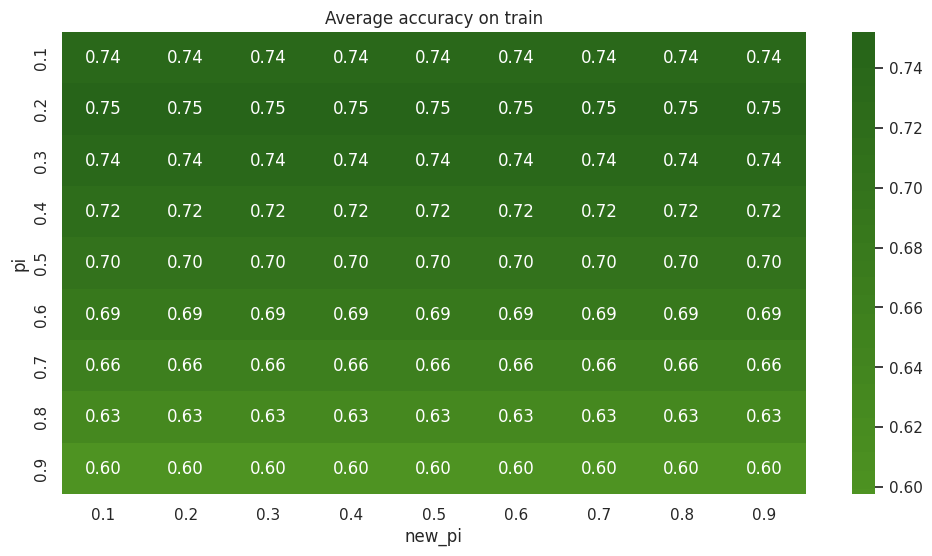

In [25]:
col = "avg_accuracy"

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Average accuracy on train")
sns.heatmap(results_df_train.pivot(index="pi", columns="new_pi", values=col), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df_train[col]),
    vmax= max(results_df_train[col]),
    center=0)
plt.show()

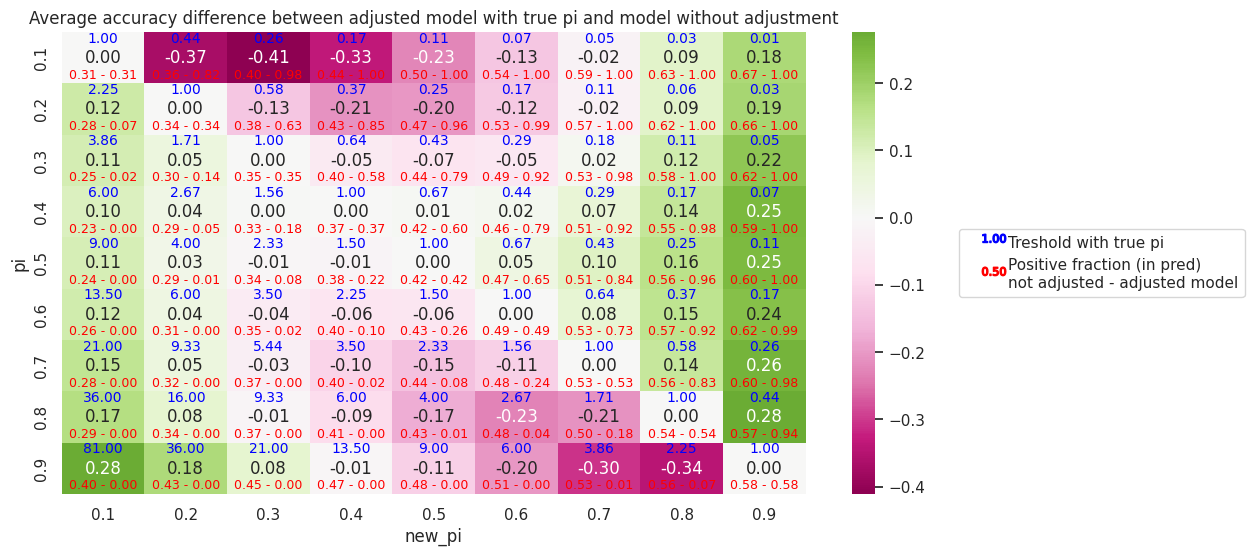

In [22]:
from matplotlib.text import TextPath

results_df["avg_true_accuracy_diff"] = results_df["avg_true_pi_accuracy"] - results_df["avg_not_adjusted_accuracy"]

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Average accuracy difference between adjusted model with true pi and model without adjustment")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_true_accuracy_diff"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_true_accuracy_diff"]),
    vmax= max(results_df["avg_true_accuracy_diff"]),
    center=0)

for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_true_pi_tres"].values[0]:.2f}', ha="center", color="blue", fontsize=10, label="True treshold")
for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.9, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_not_adjusted_pos_fraction"].values[0]:.2f} - {results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_true_pi_pos_fraction"].values[0]:.2f}', ha="center", color="red", fontsize=9, label="Positive fraction")

true_threshold_legend = plt.Line2D([], [], color="blue", marker=TextPath((0,0), '1.00'), linestyle='None', markersize=35, label="Treshold with true pi")
positive_fraction_legend = plt.Line2D([], [], color="red", marker=TextPath((0,0), '0.50'), linestyle='None', markersize=35, label="Positive fraction (in pred)\nnot adjusted - adjusted model")
plt.legend(handles=[true_threshold_legend, positive_fraction_legend], loc="center right", bbox_to_anchor=(1.6, 0.5))
plt.show()

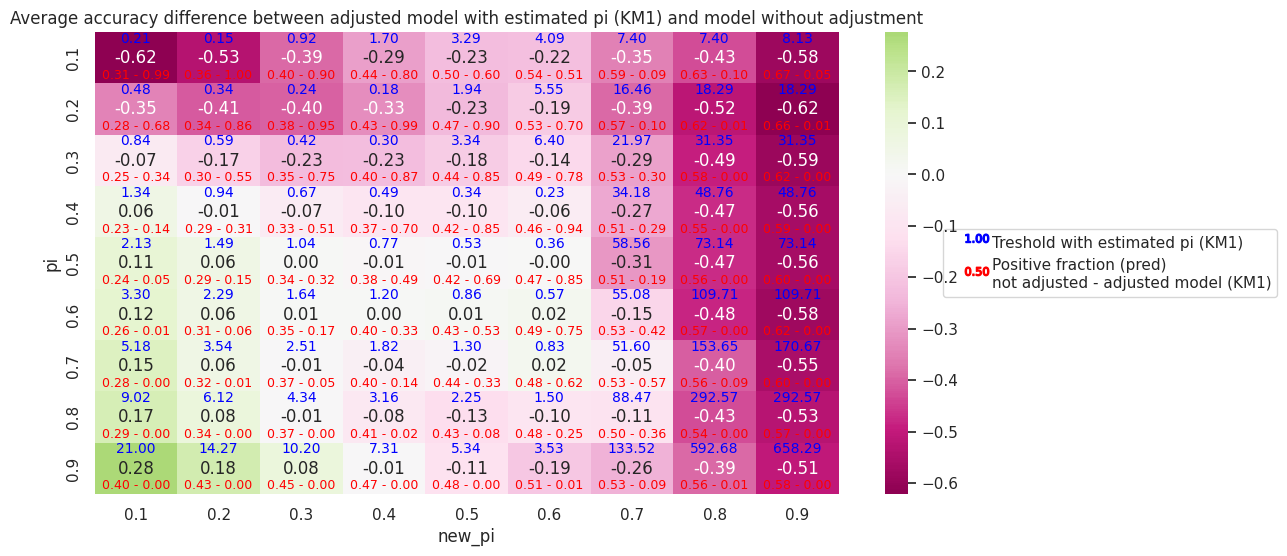

In [15]:
from matplotlib.text import TextPath

results_df["avg_km1_accuracy_diff"] = results_df["avg_km1_accuracy"] - results_df["avg_not_adjusted_accuracy"]

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Average accuracy difference between adjusted model with estimated pi (KM1) and model without adjustment")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_km1_accuracy_diff"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_km1_accuracy_diff"]),
    vmax= max(results_df["avg_km1_accuracy_diff"]),
    center=0)

for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_km1_tres"].values[0]:.2f}', ha="center", color="blue", fontsize=10, label="True treshold")
for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.9, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_not_adjusted_pos_fraction"].values[0]:.2f} - {results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_km1_pos_fraction"].values[0]:.2f}', ha="center", color="red", fontsize=9, label="Positive fraction")

true_threshold_legend = plt.Line2D([], [], color="blue", marker=TextPath((0,0), '1.00'), linestyle='None', markersize=35, label="Treshold with estimated pi (KM1)")
positive_fraction_legend = plt.Line2D([], [], color="red", marker=TextPath((0,0), '0.50'), linestyle='None', markersize=35, label="Positive fraction (pred)\nnot adjusted - adjusted model (KM1)")
plt.legend(handles=[true_threshold_legend, positive_fraction_legend], loc="center right", bbox_to_anchor=(1.6, 0.5))
plt.show()

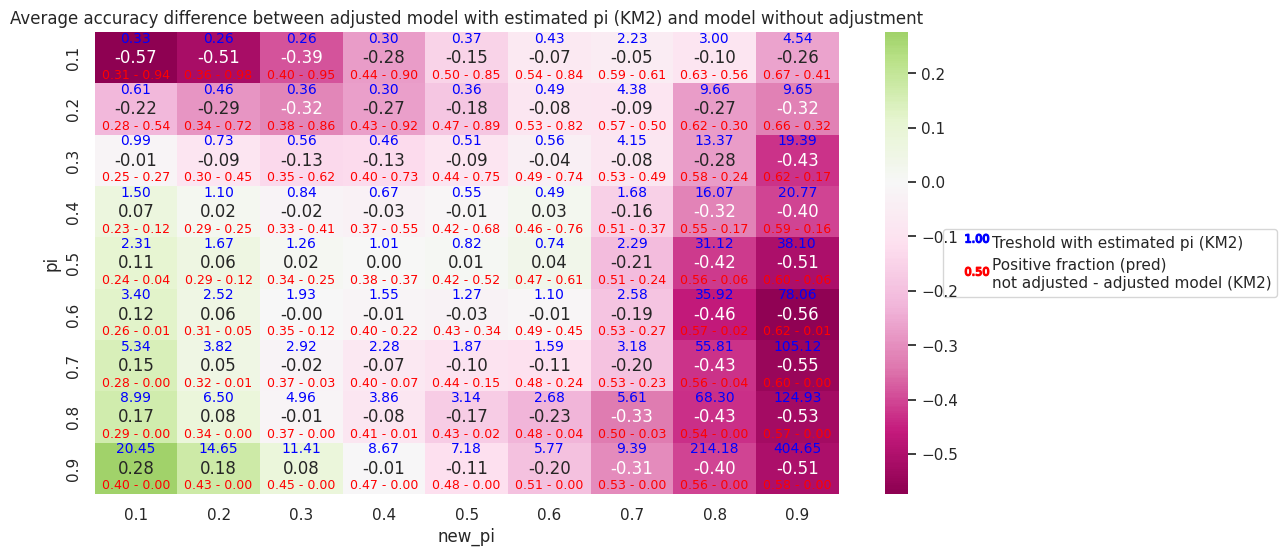

In [16]:
from matplotlib.text import TextPath

results_df["avg_km2_accuracy_diff"] = results_df["avg_km2_accuracy"] - results_df["avg_not_adjusted_accuracy"]

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Average accuracy difference between adjusted model with estimated pi (KM2) and model without adjustment")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_km2_accuracy_diff"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_km2_accuracy_diff"]),
    vmax= max(results_df["avg_km2_accuracy_diff"]),
    center=0)

for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_km2_tres"].values[0]:.2f}', ha="center", color="blue", fontsize=10, label="True treshold")
for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.9, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_not_adjusted_pos_fraction"].values[0]:.2f} - {results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_km2_pos_fraction"].values[0]:.2f}', ha="center", color="red", fontsize=9, label="Positive fraction")

true_threshold_legend = plt.Line2D([], [], color="blue", marker=TextPath((0,0), '1.00'), linestyle='None', markersize=35, label="Treshold with estimated pi (KM2)")
positive_fraction_legend = plt.Line2D([], [], color="red", marker=TextPath((0,0), '0.50'), linestyle='None', markersize=35, label="Positive fraction (pred)\nnot adjusted - adjusted model (KM2)")
plt.legend(handles=[true_threshold_legend, positive_fraction_legend], loc="center right", bbox_to_anchor=(1.6, 0.5))
plt.show()

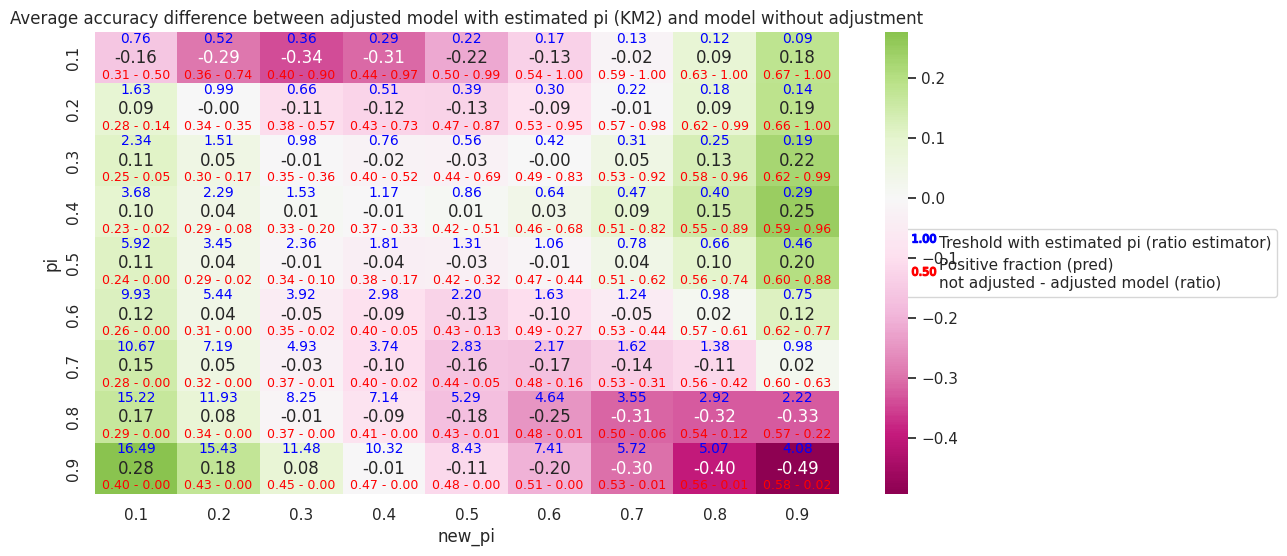

In [21]:
from matplotlib.text import TextPath

results_df["avg_ratio_accuracy_diff"] = results_df["avg_ratio_accuracy"] - results_df["avg_not_adjusted_accuracy"]

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Average accuracy difference between adjusted model with estimated pi (KM2) and model without adjustment")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_ratio_accuracy_diff"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_ratio_accuracy_diff"]),
    vmax= max(results_df["avg_ratio_accuracy_diff"]),
    center=0)

for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_ratio_tres"].values[0]:.2f}', ha="center", color="blue", fontsize=10, label="True treshold")
for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.9, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_not_adjusted_pos_fraction"].values[0]:.2f} - {results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_ratio_pos_fraction"].values[0]:.2f}', ha="center", color="red", fontsize=9, label="Positive fraction")

true_threshold_legend = plt.Line2D([], [], color="blue", marker=TextPath((0,0), '1.00'), linestyle='None', markersize=35, label="Treshold with estimated pi (ratio estimator)")
positive_fraction_legend = plt.Line2D([], [], color="red", marker=TextPath((0,0), '0.50'), linestyle='None', markersize=35, label="Positive fraction (pred)\nnot adjusted - adjusted model (ratio)")
plt.legend(handles=[true_threshold_legend, positive_fraction_legend], loc="center right", bbox_to_anchor=(1.6, 0.5))
plt.show()

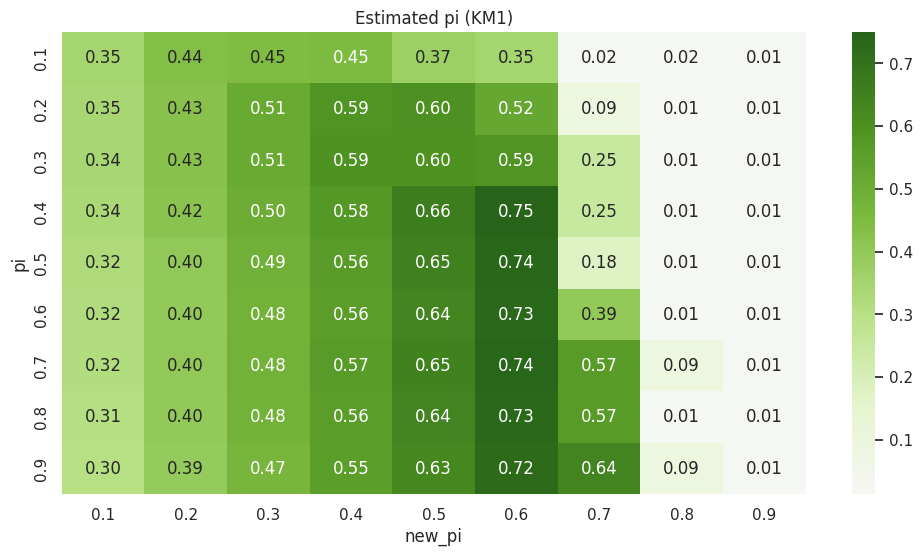

In [17]:
# plot histogram of the estimated pi (KM1) # MEAN=0.5
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Estimated pi (KM1)")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_km1_pi"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_km1_pi"]),
    vmax= max(results_df["avg_km1_pi"]),
    center=0)
plt.show()

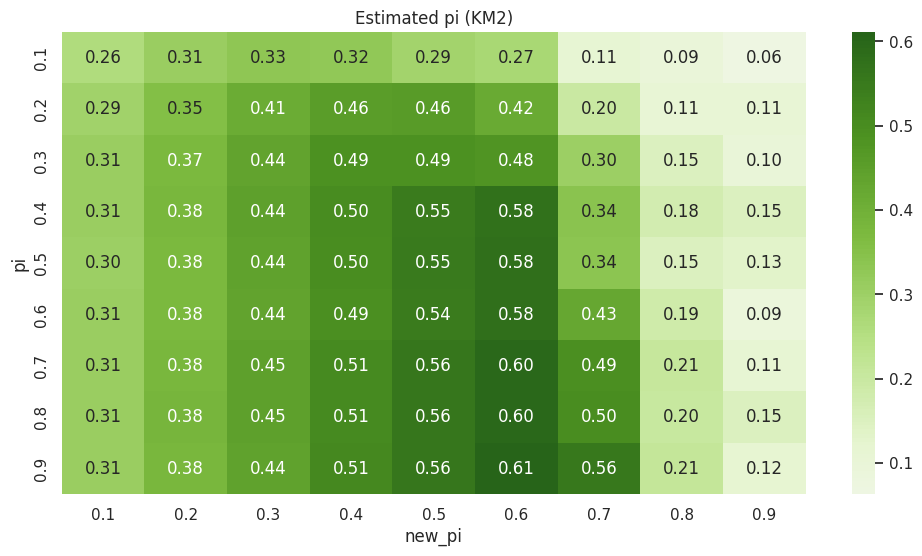

In [19]:
# plot histogram of the estimated pi (KM2) # MEAN=0.5
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Estimated pi (KM2)")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_km2_pi"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_km2_pi"]),
    vmax= max(results_df["avg_km2_pi"]),
    center=0)
plt.show()

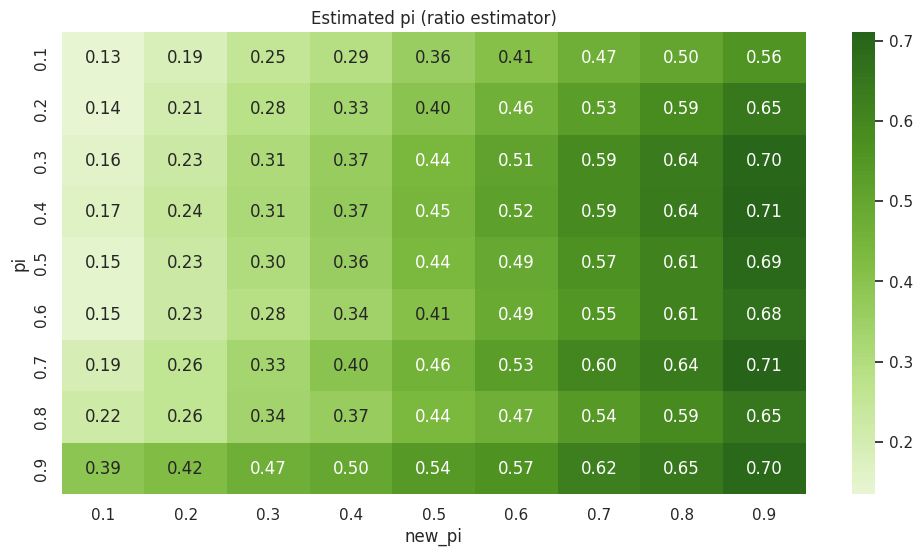

In [20]:
# plot histogram of the estimated pi (ratio) # MEAN=0.5
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Estimated pi (ratio estimator)")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_ratio_pi"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_ratio_pi"]),
    vmax= max(results_df["avg_ratio_pi"]),
    center=0)
plt.show()

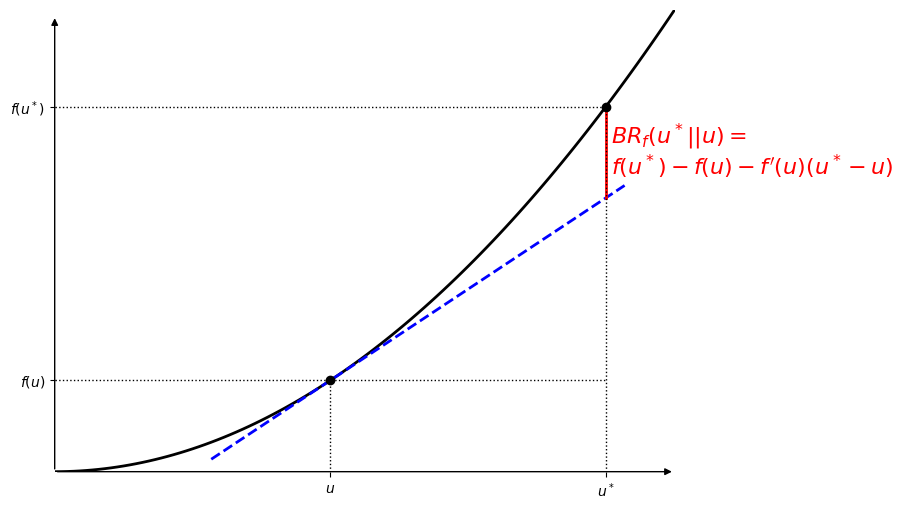

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return x**2

def f_prime(x):
    return 2*x

x = np.linspace(0, 2.25, 100)
u1 = 1
u2 = 2

f_values = f(x)
tangent_line = f(u1) + f_prime(u1) * (x - u1)

plt.figure(figsize=(8, 6))
plt.plot(x, f_values, label=r"$f(x) = x^2$", linewidth=2, color='black')
plt.plot(x[25:92], tangent_line[25:92], '--', label=f"Tangent line at $u={u1}$", linewidth=2, color='blue')
plt.scatter(u1, f(u1), color='black', label=f"$u = {u1}$", zorder=5)
plt.scatter(u2, f(u2), color='black', label=f"$u^* = {u2}$", zorder=5)

x_fill = np.linspace(u1, u2, 100)

plt.plot([u2, u2], [f(u2) , f(u1) + f_prime(u1) * (u2 - u1)], '-', color='red', linewidth=2, label="Bregman Divergence Distance")
plt.text(u2 + 0.02, f(u2) - 0.4, f"$BR_f(u^* || u) = $", fontsize=16, color="red")
plt.text(u2 + 0.02, f(u2) - 0.75, f"$f(u^*) - f(u) - f'(u)(u^* - u)$", fontsize=16, color="red")

plt.plot([u1, u1], [0, f(u1)], color='black', linewidth=1, linestyle=':')
plt.plot([u2, u2], [0, f(u2)], color='black', linewidth=1, linestyle=':')
plt.plot([0, 2], [f(u1), f(u1)], color='black', linewidth=1, linestyle=':')
plt.plot([0, 2], [f(u2), f(u2)], color='black', linewidth=1, linestyle=':')

plt.xticks([u1, u2, ], [r"$u$", r"$u^*$",])
plt.yticks([f(u1), f(u2)], [f"$f(u)$", f"$f(u^*)$"])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().margins(x=0,  y=0)
plt.annotate('', xy=(2.25, 0), xytext=(0, 0),
             arrowprops=dict(facecolor='black', arrowstyle='-|>'))
plt.annotate('', xy=(0, 5), xytext=(0, 0),
             arrowprops=dict(facecolor='black', arrowstyle='-|>'))

plt.show()